In [19]:
# Notebook analyse comparative des algorithmes Gridworld.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import warnings
import os
import json
from datetime import datetime
from pathlib import Path

# Configuration des graphiques
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)

In [20]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.rl_environments.grid_world import GridWorld 

# Imports des algorithmes 
from src.rl_algorithms.temporal_difference.q_learning import QLearning
from src.rl_algorithms.sarsa import SARSA
from src.rl_algorithms.policy_iteration import PolicyIteration
from src.rl_algorithms.value_iteration import ValueIteration
from src.rl_algorithms.monte_carlo_es import MonteCarloES
from src.rl_algorithms.on_policy_first_visit_mc_control import OnPolicyFirstVisitMCControl
from src.rl_algorithms.off_policy_mc_control import OffPolicyMCControl
from src.rl_algorithms.dyna_q import DynaQ

# Imports utilitaires
from utils.agent import Agent
from utils.file_io import save_model_with_description

OUTPUT_DIR = Path("../outputs/grid_world") 
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"📁 Répertoire d'export: {OUTPUT_DIR}")

📁 Répertoire d'export: ../outputs/grid_world


In [21]:
# 2. ENVIRONNEMENT GRIDWORLD

env = GridWorld() 

In [22]:
# 3. CONFIGURATION DES HYPERPARAMÈTRES

# Configuration des expérimentations
EXPERIMENT_CONFIG = {
    "num_episodes_td": 1000,    
    "num_episodes_mc": 3000,    # Monte Carlo nécessite plus d'épisodes
    "num_episodes_dp": None,    # Dynamic Programming (pas d'épisodes)
    "num_runs_per_config": 2,   # Runs pour moyenner les résultats
    "evaluation_episodes": 200, # Plus d'épisodes pour évaluation stable
    "random_seed": 42,          # Reproductibilité
}

# Configurations d'hyperparamètres par algorithme
HYPERPARAMETER_CONFIGS = {
    "q_learning": [
        {
            "learning_rate": 0.1,
            "gamma": 0.95,      
            "epsilon": 0.15,   
            "epsilon_decay": 0.998,
            "epsilon_min": 0.01,
            "name": "Standard",
        },
        {
            "learning_rate": 0.05,
            "gamma": 0.99,
            "epsilon": 0.25,    
            "epsilon_decay": 0.995,
            "epsilon_min": 0.02,
            "name": "Conservative",
        },
        {
            "learning_rate": 0.2,
            "gamma": 0.9,
            "epsilon": 0.3,
            "epsilon_decay": 0.99,
            "epsilon_min": 0.05,
            "name": "Aggressive",
        },
        {
            "learning_rate": 0.15,
            "gamma": 0.98,
            "epsilon": 0.1,
            "epsilon_decay": 0.999,
            "epsilon_min": 0.01,
            "name": "LowExploration",
        },
    ],
    "sarsa": [
        {
            "learning_rate": 0.1,
            "gamma": 0.95,
            "epsilon": 0.15,
            "epsilon_decay": 0.998,
            "epsilon_min": 0.01,
            "name": "Standard",
        },
        {
            "learning_rate": 0.05,
            "gamma": 0.99,
            "epsilon": 0.25,
            "epsilon_decay": 0.996,
            "epsilon_min": 0.02,
            "name": "Conservative",
        },
        {
            "learning_rate": 0.15,
            "gamma": 0.9,
            "epsilon": 0.3,
            "epsilon_decay": 0.99,
            "epsilon_min": 0.03,
            "name": "HighExploration",
        },
        {
            "learning_rate": 0.08,
            "gamma": 0.97,
            "epsilon": 0.12,
            "epsilon_decay": 0.997,
            "epsilon_min": 0.005,
            "name": "Balanced",
        },
    ],
    "value_iteration": [
        {"gamma": 0.95, "theta": 1e-6, "max_iterations": 1000, "name": "Standard"},
        {"gamma": 0.99, "theta": 1e-8, "max_iterations": 2000, "name": "HighPrecision"},
        {"gamma": 0.98, "theta": 1e-4, "max_iterations": 500, "name": "Fast"},
        {"gamma": 0.9, "theta": 1e-5, "max_iterations": 1500, "name": "LowDiscount"},
    ],
    "policy_iteration": [
        {"gamma": 0.95, "theta": 1e-5, "max_iterations": 100, "name": "Standard"},
        {"gamma": 0.99, "theta": 1e-8, "max_iterations": 200, "name": "HighPrecision"},
        {"gamma": 0.98, "theta": 1e-4, "max_iterations": 50, "name": "Fast"},
        {"gamma": 0.9, "theta": 1e-6, "max_iterations": 150, "name": "LowDiscount"},
    ],
    "monte_carlo_es": [
        {
            "gamma": 0.99,
            "epsilon": 0.2,   
            "epsilon_decay": 0.998,
            "epsilon_min": 0.02,
            "name": "Standard",
        },
        {
            "gamma": 0.95,
            "epsilon": 0.3,
            "epsilon_decay": 0.995,
            "epsilon_min": 0.03,
            "name": "HighExploration",
        },
        {
            "gamma": 0.99,
            "epsilon": 0.1,
            "epsilon_decay": 0.999,
            "epsilon_min": 0.01,
            "name": "LowExploration",
        },
        {
            "gamma": 0.97,
            "epsilon": 0.15,
            "epsilon_decay": 0.997,
            "epsilon_min": 0.015,
            "name": "Balanced",
        },
    ],
    "on_policy_mc": [
        {
            "gamma": 0.99,
            "epsilon": 0.2,
            "epsilon_decay": 0.998,
            "epsilon_min": 0.02,
            "name": "Standard",
        },
        {
            "gamma": 0.95,
            "epsilon": 0.3,
            "epsilon_decay": 0.995,
            "epsilon_min": 0.03,
            "name": "HighExploration",
        },
        {
            "gamma": 0.99,
            "epsilon": 0.1,
            "epsilon_decay": 0.999,
            "epsilon_min": 0.01,
            "name": "LowExploration",
        },
        {
            "gamma": 0.97,
            "epsilon": 0.15,
            "epsilon_decay": 0.997,
            "epsilon_min": 0.015,
            "name": "Moderate",
        },
    ],
    "off_policy_mc": [
        {
            "gamma": 0.99,
            "epsilon": 0.2,
            "epsilon_decay": 0.998,
            "epsilon_min": 0.02,
            "name": "Standard",
        },
        {
            "gamma": 0.95,
            "epsilon": 0.3,
            "epsilon_decay": 0.995,
            "epsilon_min": 0.03,
            "name": "HighExploration",
        },
        {
            "gamma": 0.99,
            "epsilon": 0.1,
            "epsilon_decay": 0.999,
            "epsilon_min": 0.01,
            "name": "LowExploration",
        },
        {
            "gamma": 0.97,
            "epsilon": 0.12,
            "epsilon_decay": 0.997,
            "epsilon_min": 0.015,
            "name": "Conservative",
        },
    ],
    "dyna_q": [
        {
            "learning_rate": 0.1,
            "gamma": 0.99,
            "epsilon": 0.2,
            "epsilon_decay": 0.998,
            "epsilon_min": 0.02,
            "n_planning_steps": 10,  
            "name": "Standard",
        },
        {
            "learning_rate": 0.15,
            "gamma": 0.95,
            "epsilon": 0.25,
            "epsilon_decay": 0.995,
            "epsilon_min": 0.03,
            "n_planning_steps": 20, 
            "name": "MorePlanning",
        },
        {
            "learning_rate": 0.1,
            "gamma": 0.99,
            "epsilon": 0.15,
            "epsilon_decay": 0.998,
            "epsilon_min": 0.02,
            "n_planning_steps": 5,
            "name": "MinimalPlanning",
        },
        {
            "learning_rate": 0.2,
            "gamma": 0.97,
            "epsilon": 0.3,
            "epsilon_decay": 0.996,
            "epsilon_min": 0.04,
            "n_planning_steps": 25,
            "name": "Intensive",
        },
    ],
}

print("⚙️ CONFIGURATION DES EXPÉRIENCES GRIDWORLD")
print("-" * 40)
print(f"Episodes TD Learning: {EXPERIMENT_CONFIG['num_episodes_td']}")
print(f"Episodes Monte Carlo: {EXPERIMENT_CONFIG['num_episodes_mc']}")
print(f"Runs par configuration: {EXPERIMENT_CONFIG['num_runs_per_config']}")
print(f"Episodes d'évaluation: {EXPERIMENT_CONFIG['evaluation_episodes']}")

# Affichage du nombre de configurations par algorithme
for algo_name, configs in HYPERPARAMETER_CONFIGS.items():
    print(f"{algo_name}: {len(configs)} configurations")

⚙️ CONFIGURATION DES EXPÉRIENCES GRIDWORLD
----------------------------------------
Episodes TD Learning: 1000
Episodes Monte Carlo: 3000
Runs par configuration: 2
Episodes d'évaluation: 200
q_learning: 4 configurations
sarsa: 4 configurations
value_iteration: 4 configurations
policy_iteration: 4 configurations
monte_carlo_es: 4 configurations
on_policy_mc: 4 configurations
off_policy_mc: 4 configurations
dyna_q: 4 configurations


In [23]:
# 4. FONCTIONS POUR L'EXPÉRIMENTATION
def run_algorithm_experiment(algorithm_class, algorithm_name, config, env, num_episodes, run_id=0):
    print(f"  🔄 Run {run_id + 1} - {algorithm_name.upper()} ({config['name']})")

    # Initialisation avec graine aléatoire pour reproductibilité
    np.random.seed(EXPERIMENT_CONFIG["random_seed"] + run_id)

    start_time = time.time()

    try:
        # Création de l'algorithme via from_config()
        algorithm = algorithm_class.from_config(config, env)

        # Entraînement selon le type d'algorithme
        if algorithm_name in ["value_iteration", "policy_iteration"]:
            # Programmation dynamique : pas d'épisodes
            training_results = algorithm.train(env, num_episodes=None, verbose=False)
            episode_rewards = [training_results.get("max_value", 0)]
        else:
            # Algorithmes basés sur l'expérience
            training_results = algorithm.train(env, num_episodes, verbose=False)
            # Extraction des récompenses d'entraînement
            if hasattr(algorithm, "training_history") and algorithm.training_history:
                episode_rewards = [ep["reward"] for ep in algorithm.training_history]
            else:
                episode_rewards = training_results.get("episode_rewards", [0])

    except Exception as e:
        print(f"    Erreur lors de l'entraînement: {e}")
        return None

    training_time = time.time() - start_time

    # Évaluation des performances avec Agent wrapper
    try:
        agent = Agent(algorithm, env, f"{algorithm_name}_{config['name']}")
        eval_results = agent.evaluate_performance(
            num_episodes=EXPERIMENT_CONFIG["evaluation_episodes"],
            verbose=False,
            success_criterion="auto",
        )
        final_performance = eval_results["avg_reward"]
        success_rate = eval_results["success_rate"]
        avg_episode_length = eval_results["avg_episode_length"]

    except Exception as e:
        print(f"   Erreur lors de l'évaluation: {e}")
        # Fallback en cas d'erreur
        final_performance = episode_rewards[-1] if episode_rewards else 0
        success_rate = 0.0
        avg_episode_length = 0.0

    # Calcul des métriques de convergence
    if len(episode_rewards) > 100:  # GridWorld nécessite plus d'épisodes
        # Vitesse de convergence
        window_size = min(100, len(episode_rewards) // 4)  # AUGMENTÉ
        moving_avg = pd.Series(episode_rewards).rolling(window=window_size).mean().dropna()

        if len(moving_avg) > 20:  # 
            stability_threshold = 0.2  # GridWorld plus variable
            diff = np.abs(np.diff(moving_avg))
            stable_episodes = np.where(diff < stability_threshold)[0]
            convergence_episode = (
                stable_episodes[0] + window_size
                if len(stable_episodes) > 0
                else len(episode_rewards)
            )
        else:
            convergence_episode = len(episode_rewards)

        # Stabilité
        last_20_percent = episode_rewards[-len(episode_rewards) // 5 :]
        if len(last_20_percent) > 0:
            stability = np.std(last_20_percent) / (np.mean(last_20_percent) + 1e-8)
        else:
            stability = 0.0
    else:
        convergence_episode = 1
        stability = 0.0

    return {
        "algorithm": algorithm_name,
        "config_name": config["name"],
        "run_id": run_id,
        "training_time": training_time,
        "final_performance": final_performance,
        "success_rate": success_rate,
        "avg_episode_length": avg_episode_length,
        "convergence_episode": convergence_episode,
        "stability": stability,
        "episode_rewards": episode_rewards,
        "total_episodes": len(episode_rewards),
        "algorithm_object": algorithm,
        "hyperparameters": config.copy(),
    }

In [24]:
def plot_algorithm_convergence(results_list, algorithm_name, save_path=None):
    """
    Graphique de convergence pour un algorithme avec ses différentes configurations.

    
    Args:
        results_list: Liste des résultats pour cet algorithme
        algorithm_name: Nom de l'algorithme
        save_path: Chemin de sauvegarde optionnel
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique 1: Courbes de récompenses
    config_names = list(set([r['config_name'] for r in results_list]))
    colors = plt.cm.Set1(np.linspace(0, 1, len(config_names)))
    
    for i, config_name in enumerate(config_names):
        config_results = [r for r in results_list if r['config_name'] == config_name]
        
        # Collecte des récompenses pour cette configuration
        all_rewards = []
        max_episodes = 0
        
        for result in config_results:
            rewards = result['episode_rewards']
            if len(rewards) > max_episodes:
                max_episodes = len(rewards)
            all_rewards.append(rewards)
        
        if max_episodes > 0:
            # Alignement des séries (padding avec dernière valeur)
            aligned_rewards = []
            for rewards in all_rewards:
                if len(rewards) < max_episodes:
                    padded = list(rewards) + [rewards[-1]] * (max_episodes - len(rewards))
                else:
                    padded = rewards[:max_episodes]
                aligned_rewards.append(padded)
            
            # Calcul des moyennes et écarts-types
            mean_rewards = np.mean(aligned_rewards, axis=0)
            std_rewards = np.std(aligned_rewards, axis=0)
            episodes = range(len(mean_rewards))
            
            # Lissage avec moyenne mobile (léger)
            window = min(50, len(mean_rewards) // 10) if len(mean_rewards) > 10 else 1
            if window > 1:
                mean_smooth = pd.Series(mean_rewards).rolling(window=window).mean()
                
                upper_bound = np.minimum(mean_smooth + std_rewards, 1.0)   # Max goal
                lower_bound = np.maximum(mean_smooth - std_rewards, -3.0)  # Min losing
                
                ax1.plot(episodes, mean_smooth, label=config_name, linewidth=2, color=colors[i])
                ax1.fill_between(episodes, lower_bound, upper_bound, 
                                alpha=0.2, color=colors[i])
            else:
                ax1.plot(episodes, mean_rewards, label=config_name, linewidth=2, color=colors[i])
    
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Reward")
    ax1.set_title(f"{algorithm_name.upper()} - Convergence GridWorld")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax1.set_ylim([-3.5, 1.5]) 
    
    ax1.axhline(y=1.0, color='green', linestyle='--', alpha=0.7, label='Goal (+1.0)')
    ax1.axhline(y=-3.0, color='red', linestyle='--', alpha=0.7, label='Losing (-3.0)')
    ax1.axhline(y=0.0, color='gray', linestyle=':', alpha=0.5, label='Neutral (0.0)')
    ax1.legend()
    
    # Graphique 2: Métriques de performance par configuration 
    metrics_data = []
    for config_name in config_names:
        config_results = [r for r in results_list if r['config_name'] == config_name]
        
        metrics_data.append({
            'Configuration': config_name,
            'Performance': np.mean([r['final_performance'] for r in config_results]),
            'Performance_Std': np.std([r['final_performance'] for r in config_results]),
            'Convergence': np.mean([r['convergence_episode'] for r in config_results]),
            'Temps': np.mean([r['training_time'] for r in config_results])
        })
    
    metrics_df = pd.DataFrame(metrics_data)
    
    x = range(len(metrics_df))
    width = 0.25
    
    ax2.bar([i - width for i in x], metrics_df['Performance'], width, 
            label='Performance Finale', alpha=0.8, color=colors[0])
    ax2.bar([i for i in x], metrics_df['Convergence'] / 100, width, 
            label='Convergence (/100)', alpha=0.8, color=colors[1])
    ax2.bar([i + width for i in x], metrics_df['Temps'], width, 
            label='Temps (s)', alpha=0.8, color=colors[2])
    
    ax2.set_xlabel("Configuration")
    ax2.set_ylabel("Valeur")
    ax2.set_title(f"{algorithm_name.upper()} - Métriques GridWorld")
    ax2.set_xticks(x)
    ax2.set_xticklabels(metrics_df['Configuration'], rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path / f"{algorithm_name}_convergence_gridworld.png", 
                   dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return metrics_df

In [25]:
# 5. ENTRAÎNEMENT SYSTÉMATIQUE DES ALGORITHMES

# Stockage des résultats
all_results = []
failed_experiments = []

ALGORITHM_CLASSES = {
    "q_learning": QLearning,
    "sarsa": SARSA,
    "value_iteration": ValueIteration,
    "policy_iteration": PolicyIteration,
    "monte_carlo_es": MonteCarloES,
    "on_policy_mc": OnPolicyFirstVisitMCControl,
    "off_policy_mc": OffPolicyMCControl,
    "dyna_q": DynaQ,
}

print("DÉBUT EXPÉRIMENTATIONS GRIDWORLD")
print("=" * 50)

# Fonction sauvegarde
def save_algorithm_model(algorithm, algorithm_name, config_name, performance, base_dir):
    """Sauvegarde un modèle entraîné avec sa description pour GridWorld."""
    try:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_name = f"{algorithm_name}_{config_name}"
        model_path = base_dir / model_name

        # Extraction des hyperparamètres
        if hasattr(algorithm, "learning_rate"):
            hyperparams = {
                "learning_rate": getattr(algorithm, "learning_rate", None),
                "gamma": getattr(algorithm, "gamma", None),
                "epsilon": getattr(algorithm, "epsilon", None),
                "epsilon_decay": getattr(algorithm, "epsilon_decay", None),
                "epsilon_min": getattr(algorithm, "epsilon_min", None),
            }
        else:
            hyperparams = {
                "gamma": getattr(algorithm, "gamma", None),
                "theta": getattr(algorithm, "theta", None),
                "max_iterations": getattr(algorithm, "max_iterations", None),
            }

        # Métriques de performance pour GridWorld
        metrics = {
            "final_performance": performance,
            "algorithm_type": algorithm_name,
            "configuration": config_name,
            "training_time": time.time(),
            "environment": "GridWorld",
            "environment_complexity": "5x5 grid, 25 states, 4 actions",
        }

        # Sauvegarde avec description
        saved_path = save_model_with_description(
            algorithm, "GridWorld", algorithm_name, hyperparams, metrics, str(base_dir)
        )

        return saved_path

    except Exception as e:
        print(f"         Erreur sauvegarde modèle {algorithm_name}: {e}")
        return None

DÉBUT EXPÉRIMENTATIONS GRIDWORLD


In [26]:
# 5.1 TEMPORAL DIFFERENCE LEARNING
print("\n🔲 TEMPORAL DIFFERENCE LEARNING")
print("-" * 40)

for algo_name in ["q_learning", "sarsa"]:
    print(f"\n {algo_name.upper()}")
    print("-" * 30)

    algorithm_class = ALGORITHM_CLASSES[algo_name]
    configs = HYPERPARAMETER_CONFIGS[algo_name]

    for config in configs:
        print(f"\n🔧 Configuration: {config['name']}")

        for run in range(EXPERIMENT_CONFIG["num_runs_per_config"]):
            env_copy = GridWorld() 

            result = run_algorithm_experiment(
                algorithm_class,
                algo_name,
                config,
                env_copy,
                EXPERIMENT_CONFIG["num_episodes_td"],
                run,
            )

            if result:
                all_results.append(result)

                # Sauvegarde du meilleur modèle de cette configuration
                if run == 0:  # Sauvegarder seulement le premier run
                    save_algorithm_model(
                        result["algorithm_object"],
                        algo_name,
                        config["name"],
                        result["final_performance"],
                        OUTPUT_DIR,
                    )
            else:
                failed_experiments.append(f"{algo_name}_{config['name']}_run{run}")


🔲 TEMPORAL DIFFERENCE LEARNING
----------------------------------------

 Q_LEARNING
------------------------------

🔧 Configuration: Standard
  🔄 Run 1 - Q_LEARNING (Standard)
✅ Agent créé: q_learning_Standard
  🔄 Run 2 - Q_LEARNING (Standard)
✅ Agent créé: q_learning_Standard

🔧 Configuration: Conservative
  🔄 Run 1 - Q_LEARNING (Conservative)
✅ Agent créé: q_learning_Conservative
  🔄 Run 2 - Q_LEARNING (Conservative)
✅ Agent créé: q_learning_Conservative

🔧 Configuration: Aggressive
  🔄 Run 1 - Q_LEARNING (Aggressive)
✅ Agent créé: q_learning_Aggressive
  🔄 Run 2 - Q_LEARNING (Aggressive)
✅ Agent créé: q_learning_Aggressive

🔧 Configuration: LowExploration
  🔄 Run 1 - Q_LEARNING (LowExploration)
✅ Agent créé: q_learning_LowExploration
  🔄 Run 2 - Q_LEARNING (LowExploration)
✅ Agent créé: q_learning_LowExploration

 SARSA
------------------------------

🔧 Configuration: Standard
  🔄 Run 1 - SARSA (Standard)
✅ Agent créé: sarsa_Standard
  🔄 Run 2 - SARSA (Standard)
✅ Agent créé: sars

In [27]:
# 5.2 PROGRAMMATION DYNAMIQUE
print("\n🔄 PROGRAMMATION DYNAMIQUE")
print("-" * 40)

for algo_name in ["value_iteration", "policy_iteration"]:
    print(f"\n {algo_name.upper()}")
    print("-" * 30)

    algorithm_class = ALGORITHM_CLASSES[algo_name]
    configs = HYPERPARAMETER_CONFIGS[algo_name]

    for config in configs:
        print(f"\n🔧 Configuration: {config['name']}")

        for run in range(EXPERIMENT_CONFIG["num_runs_per_config"]):
            env_copy = GridWorld()  # CHANGEMENT: GridWorld

            result = run_algorithm_experiment(
                algorithm_class,
                algo_name,
                config,
                env_copy,
                EXPERIMENT_CONFIG["num_episodes_dp"],
                run,
            )

            if result:
                all_results.append(result)

                # Sauvegarde du modèle
                if run == 0:
                    save_algorithm_model(
                        result["algorithm_object"],
                        algo_name,
                        config["name"],
                        result["final_performance"],
                        OUTPUT_DIR,
                    )
            else:
                failed_experiments.append(f"{algo_name}_{config['name']}_run{run}")


🔄 PROGRAMMATION DYNAMIQUE
----------------------------------------

 VALUE_ITERATION
------------------------------

🔧 Configuration: Standard
  🔄 Run 1 - VALUE_ITERATION (Standard)
✅ Agent créé: value_iteration_Standard
  🔄 Run 2 - VALUE_ITERATION (Standard)
✅ Agent créé: value_iteration_Standard

🔧 Configuration: HighPrecision
  🔄 Run 1 - VALUE_ITERATION (HighPrecision)
✅ Agent créé: value_iteration_HighPrecision
  🔄 Run 2 - VALUE_ITERATION (HighPrecision)
✅ Agent créé: value_iteration_HighPrecision

🔧 Configuration: Fast
  🔄 Run 1 - VALUE_ITERATION (Fast)
✅ Agent créé: value_iteration_Fast
  🔄 Run 2 - VALUE_ITERATION (Fast)
✅ Agent créé: value_iteration_Fast

🔧 Configuration: LowDiscount
  🔄 Run 1 - VALUE_ITERATION (LowDiscount)
✅ Agent créé: value_iteration_LowDiscount
  🔄 Run 2 - VALUE_ITERATION (LowDiscount)
✅ Agent créé: value_iteration_LowDiscount

 POLICY_ITERATION
------------------------------

🔧 Configuration: Standard
  🔄 Run 1 - POLICY_ITERATION (Standard)
✅ Agent créé: 

In [28]:
# 5.3 MÉTHODES MONTE CARLO 
print("\n🎲 MÉTHODES MONTE CARLO")
print("-" * 40)

for algo_name in ["monte_carlo_es", "on_policy_mc", "off_policy_mc"]:
    print(f"\n {algo_name.upper()}")
    print("-" * 30)

    algorithm_class = ALGORITHM_CLASSES[algo_name]
    configs = HYPERPARAMETER_CONFIGS[algo_name]

    for config in configs:
        print(f"\n🔧 Configuration: {config['name']}")

        for run in range(EXPERIMENT_CONFIG["num_runs_per_config"]):
            env_copy = GridWorld() 

            result = run_algorithm_experiment(
                algorithm_class,
                algo_name,
                config,
                env_copy,
                EXPERIMENT_CONFIG["num_episodes_mc"],
                run,
            )

            if result:
                all_results.append(result)

                # Sauvegarde du modèle
                if run == 0:
                    save_algorithm_model(
                        result["algorithm_object"],
                        algo_name,
                        config["name"],
                        result["final_performance"],
                        OUTPUT_DIR,
                    )
            else:
                failed_experiments.append(f"{algo_name}_{config['name']}_run{run}")


🎲 MÉTHODES MONTE CARLO
----------------------------------------

 MONTE_CARLO_ES
------------------------------

🔧 Configuration: Standard
  🔄 Run 1 - MONTE_CARLO_ES (Standard)
✅ Agent créé: monte_carlo_es_Standard
  🔄 Run 2 - MONTE_CARLO_ES (Standard)
✅ Agent créé: monte_carlo_es_Standard

🔧 Configuration: HighExploration
  🔄 Run 1 - MONTE_CARLO_ES (HighExploration)
✅ Agent créé: monte_carlo_es_HighExploration
  🔄 Run 2 - MONTE_CARLO_ES (HighExploration)
✅ Agent créé: monte_carlo_es_HighExploration

🔧 Configuration: LowExploration
  🔄 Run 1 - MONTE_CARLO_ES (LowExploration)
✅ Agent créé: monte_carlo_es_LowExploration
  🔄 Run 2 - MONTE_CARLO_ES (LowExploration)
✅ Agent créé: monte_carlo_es_LowExploration

🔧 Configuration: Balanced
  🔄 Run 1 - MONTE_CARLO_ES (Balanced)
✅ Agent créé: monte_carlo_es_Balanced
  🔄 Run 2 - MONTE_CARLO_ES (Balanced)
✅ Agent créé: monte_carlo_es_Balanced

 ON_POLICY_MC
------------------------------

🔧 Configuration: Standard
  🔄 Run 1 - ON_POLICY_MC (Standar

In [29]:
# 5.4 PLANNING METHODS 
print("\n PLANNING METHODS")
print("-" * 40)

algo_name = "dyna_q"
print(f"\n {algo_name.upper()}")
print("-" * 30)

algorithm_class = ALGORITHM_CLASSES[algo_name]
configs = HYPERPARAMETER_CONFIGS[algo_name]

for config in configs:
    print(f"\n🔧 Configuration: {config['name']}")

    for run in range(EXPERIMENT_CONFIG["num_runs_per_config"]):
        env_copy = GridWorld() 

        result = run_algorithm_experiment(
            algorithm_class,
            algo_name,
            config,
            env_copy,
            EXPERIMENT_CONFIG["num_episodes_td"],
            run,
        )

        if result:
            all_results.append(result)

            # Sauvegarde du modèle
            if run == 0:
                save_algorithm_model(
                    result["algorithm_object"],
                    algo_name,
                    config["name"],
                    result["final_performance"],
                    OUTPUT_DIR,
                )
        else:
            failed_experiments.append(f"{algo_name}_{config['name']}_run{run}")

# Résumé des expérimentations
print(f"\n EXPÉRIMENTATIONS TERMINÉES")
print("=" * 40)
print(f"Expériences réussies: {len(all_results)}")
print(f"Expériences échouées: {len(failed_experiments)}")

if failed_experiments:
    print("⚠️ Expériences échouées:")
    for exp in failed_experiments:
        print(f"  - {exp}")


 PLANNING METHODS
----------------------------------------

 DYNA_Q
------------------------------

🔧 Configuration: Standard
  🔄 Run 1 - DYNA_Q (Standard)
✅ Agent créé: dyna_q_Standard
  🔄 Run 2 - DYNA_Q (Standard)
✅ Agent créé: dyna_q_Standard

🔧 Configuration: MorePlanning
  🔄 Run 1 - DYNA_Q (MorePlanning)
✅ Agent créé: dyna_q_MorePlanning
  🔄 Run 2 - DYNA_Q (MorePlanning)
✅ Agent créé: dyna_q_MorePlanning

🔧 Configuration: MinimalPlanning
  🔄 Run 1 - DYNA_Q (MinimalPlanning)
✅ Agent créé: dyna_q_MinimalPlanning
  🔄 Run 2 - DYNA_Q (MinimalPlanning)
✅ Agent créé: dyna_q_MinimalPlanning

🔧 Configuration: Intensive
  🔄 Run 1 - DYNA_Q (Intensive)
✅ Agent créé: dyna_q_Intensive
  🔄 Run 2 - DYNA_Q (Intensive)
✅ Agent créé: dyna_q_Intensive

 EXPÉRIMENTATIONS TERMINÉES
Expériences réussies: 64
Expériences échouées: 0


In [30]:
# 6. CONSOLIDATION ET ANALYSE DES RÉSULTATS

# Conversion en DataFrame pour faciliter l'analyse
results_df = pd.DataFrame(all_results)

print("CONSOLIDATION DES RÉSULTATS GRIDWORLD")
print("-" * 40)
print(f"Total des expériences: {len(results_df)}")
print(f"Algorithmes testés: {list(results_df['algorithm'].unique())}")

# Aperçu des données
print("\n Aperçu des résultats:")
print(results_df[["algorithm", "config_name", "final_performance", 
                 "convergence_episode", "training_time"]].head(10))

# Statistiques générales par algorithme
print("\nSTATISTIQUES GÉNÉRALES PAR ALGORITHME")
print("-" * 50)

general_stats = (
    results_df.groupby("algorithm")
    .agg({
        "final_performance": ["mean", "std", "max", "min"],
        "convergence_episode": ["mean", "std"],
        "training_time": ["mean", "std"],
        "success_rate": ["mean", "std"],
        "stability": ["mean", "std"],
    })
    .round(4)
)

print(general_stats)

CONSOLIDATION DES RÉSULTATS GRIDWORLD
----------------------------------------
Total des expériences: 64
Algorithmes testés: ['q_learning', 'sarsa', 'value_iteration', 'policy_iteration', 'monte_carlo_es', 'on_policy_mc', 'off_policy_mc', 'dyna_q']

 Aperçu des résultats:
    algorithm     config_name  final_performance  convergence_episode  \
0  q_learning        Standard                0.0                  100   
1  q_learning        Standard                0.0                  100   
2  q_learning    Conservative                0.0                  100   
3  q_learning    Conservative                0.0                  100   
4  q_learning      Aggressive                0.0                  100   
5  q_learning      Aggressive                0.0                  100   
6  q_learning  LowExploration                0.0                  100   
7  q_learning  LowExploration                0.0                  100   
8       sarsa        Standard                1.0                  100 


🔍 ANALYSE DÉTAILLÉE PAR ALGORITHME - GRIDWORLD

 Q_LEARNING
------------------------------
Meilleure configuration: Aggressive
Performance moyenne: 0.0000
Convergence moyenne: 100.0 épisodes
Temps moyen: 2.148s


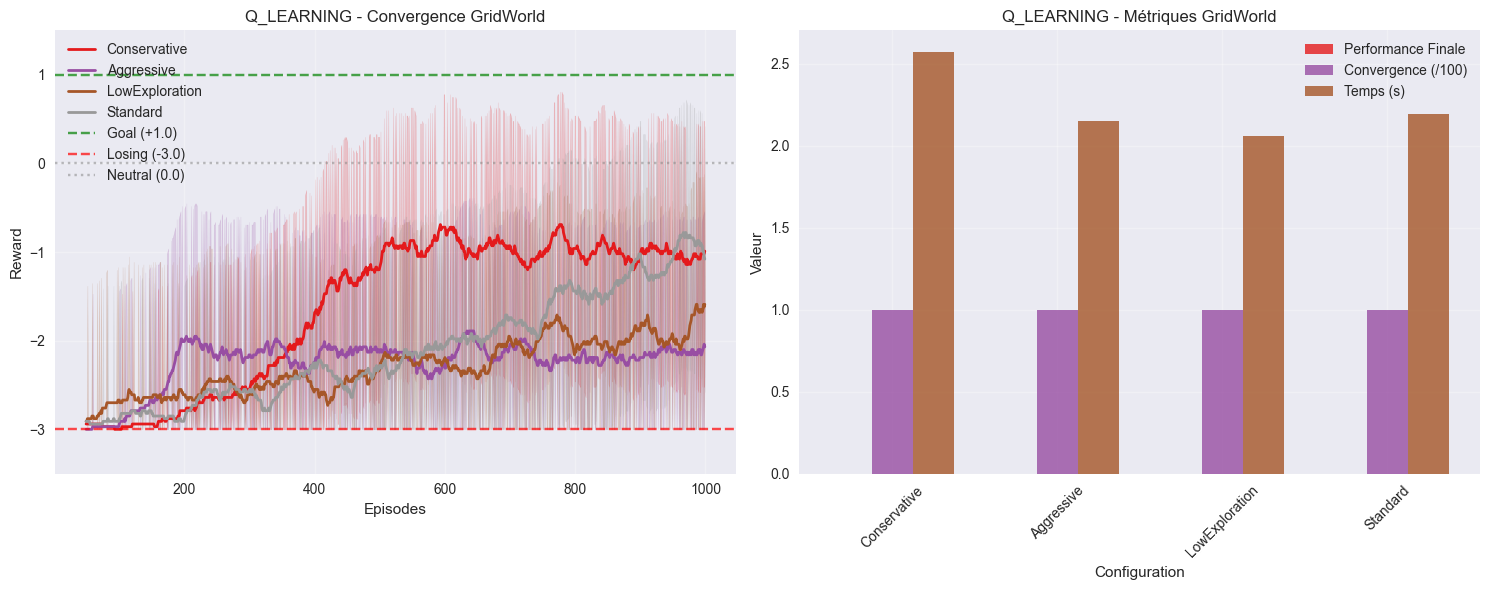

Graphique sauvegardé pour q_learning

 SARSA
------------------------------
Meilleure configuration: Balanced
Performance moyenne: 1.0000
Convergence moyenne: 100.0 épisodes
Temps moyen: 0.041s


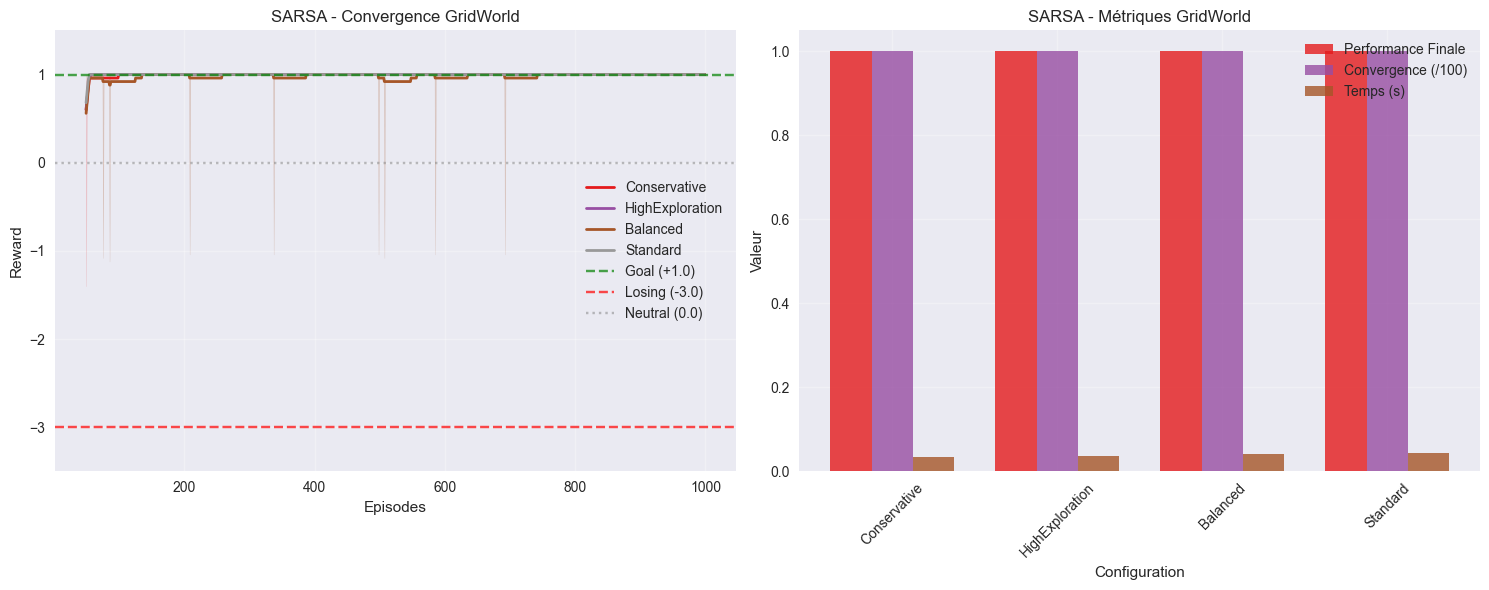

Graphique sauvegardé pour sarsa

 VALUE_ITERATION
------------------------------
Meilleure configuration: Fast
Performance moyenne: 1.0000
Convergence moyenne: 1.0 épisodes
Temps moyen: 0.067s


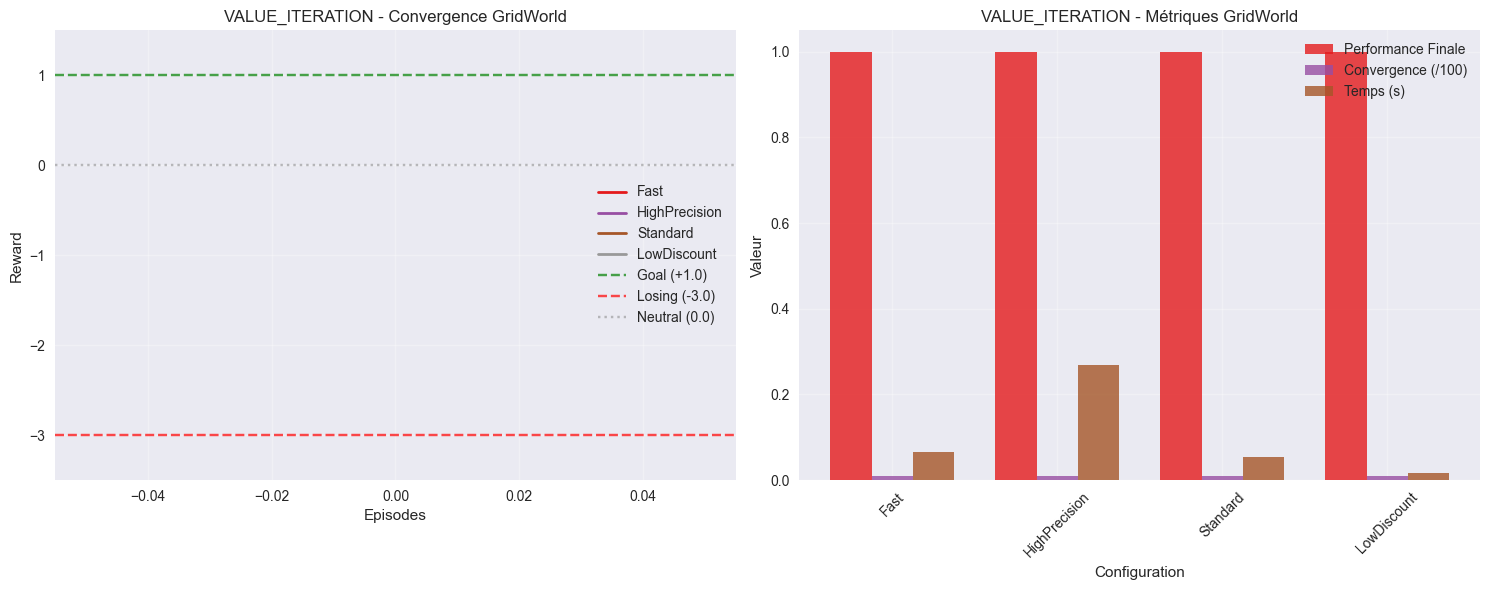

Graphique sauvegardé pour value_iteration

 POLICY_ITERATION
------------------------------
Meilleure configuration: Fast
Performance moyenne: 1.0000
Convergence moyenne: 1.0 épisodes
Temps moyen: 0.010s


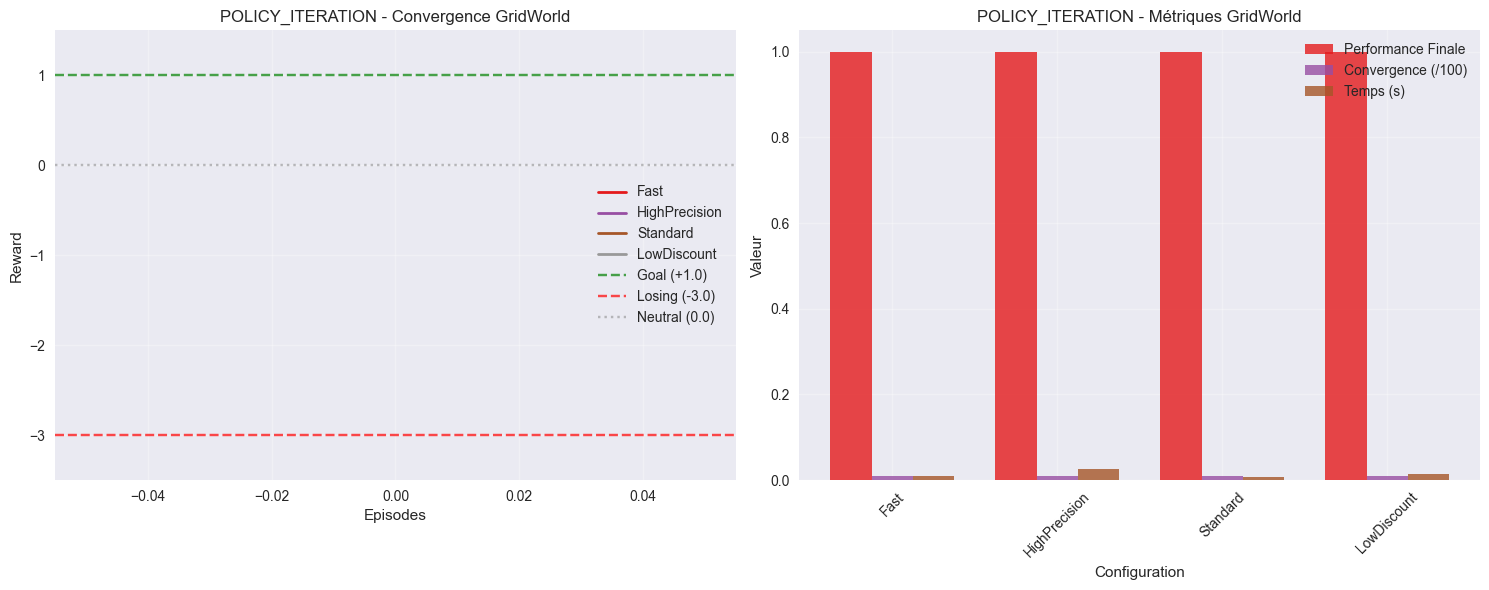

Graphique sauvegardé pour policy_iteration

 MONTE_CARLO_ES
------------------------------
Meilleure configuration: Balanced
Performance moyenne: 1.0000
Convergence moyenne: 100.0 épisodes
Temps moyen: 0.240s


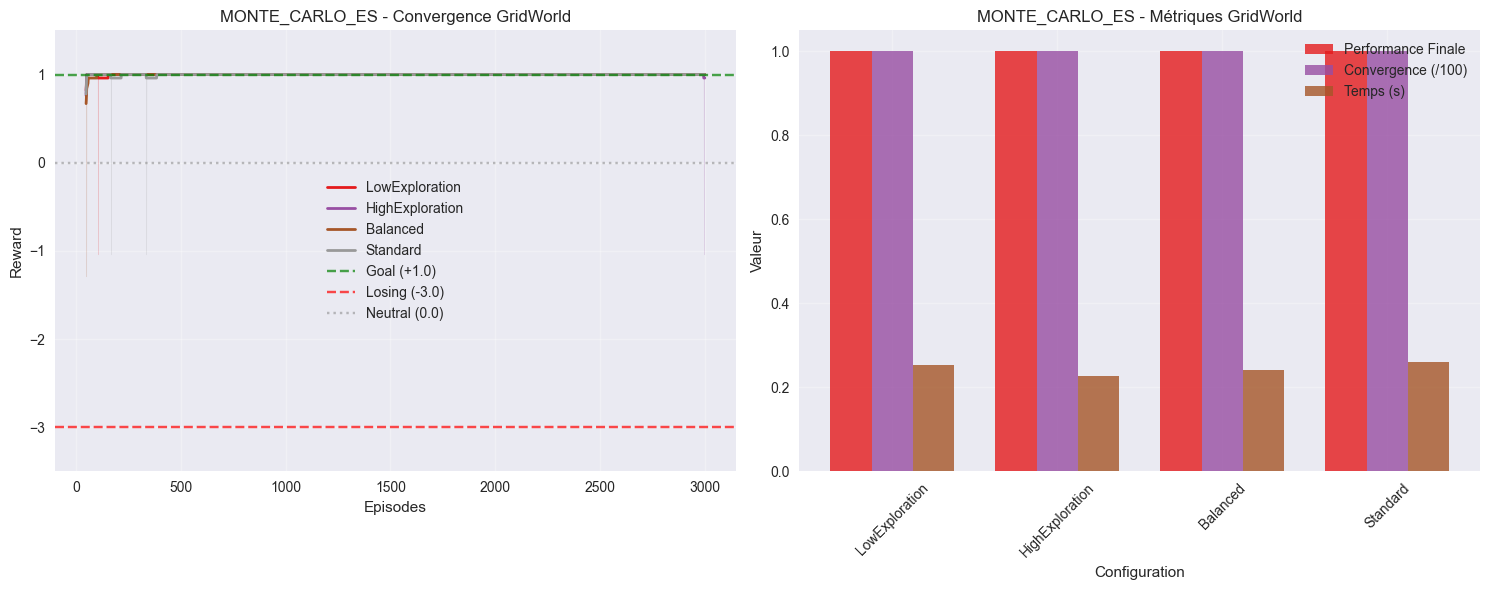

Graphique sauvegardé pour monte_carlo_es

 ON_POLICY_MC
------------------------------
Meilleure configuration: HighExploration
Performance moyenne: 1.0000
Convergence moyenne: 100.0 épisodes
Temps moyen: 1.122s


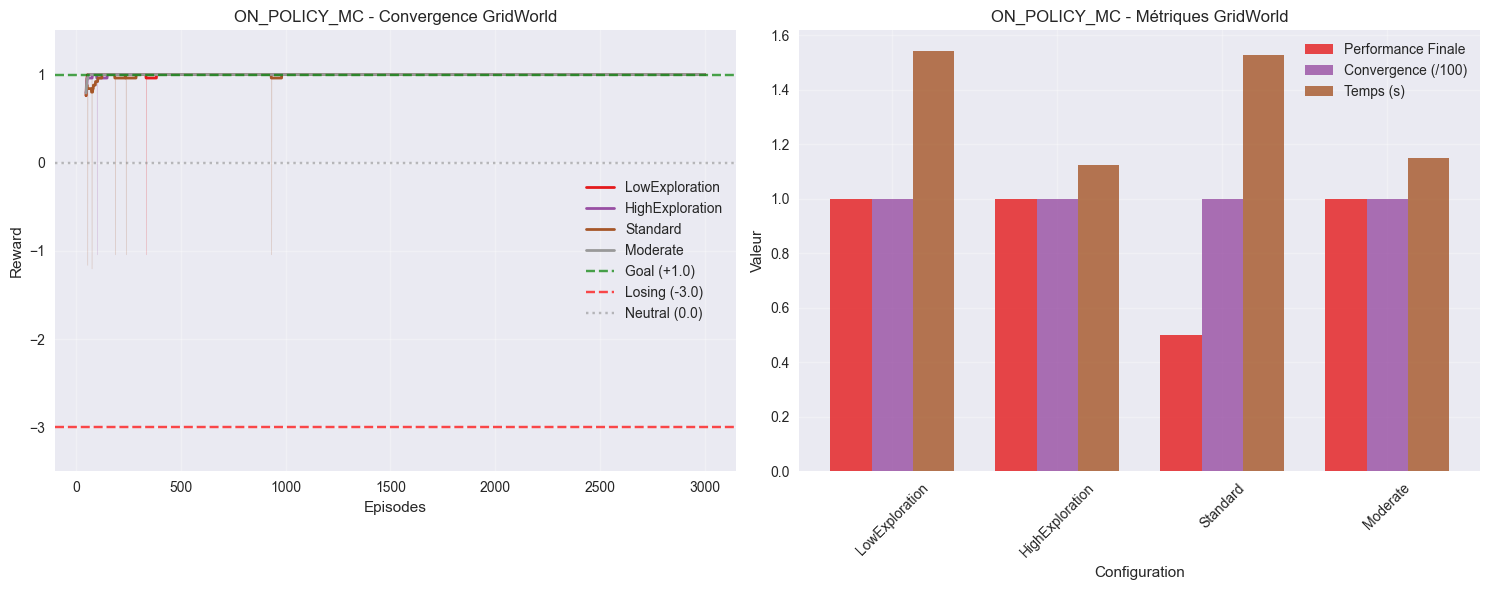

Graphique sauvegardé pour on_policy_mc

 OFF_POLICY_MC
------------------------------
Meilleure configuration: Conservative
Performance moyenne: 0.0000
Convergence moyenne: 100.0 épisodes
Temps moyen: 7.501s


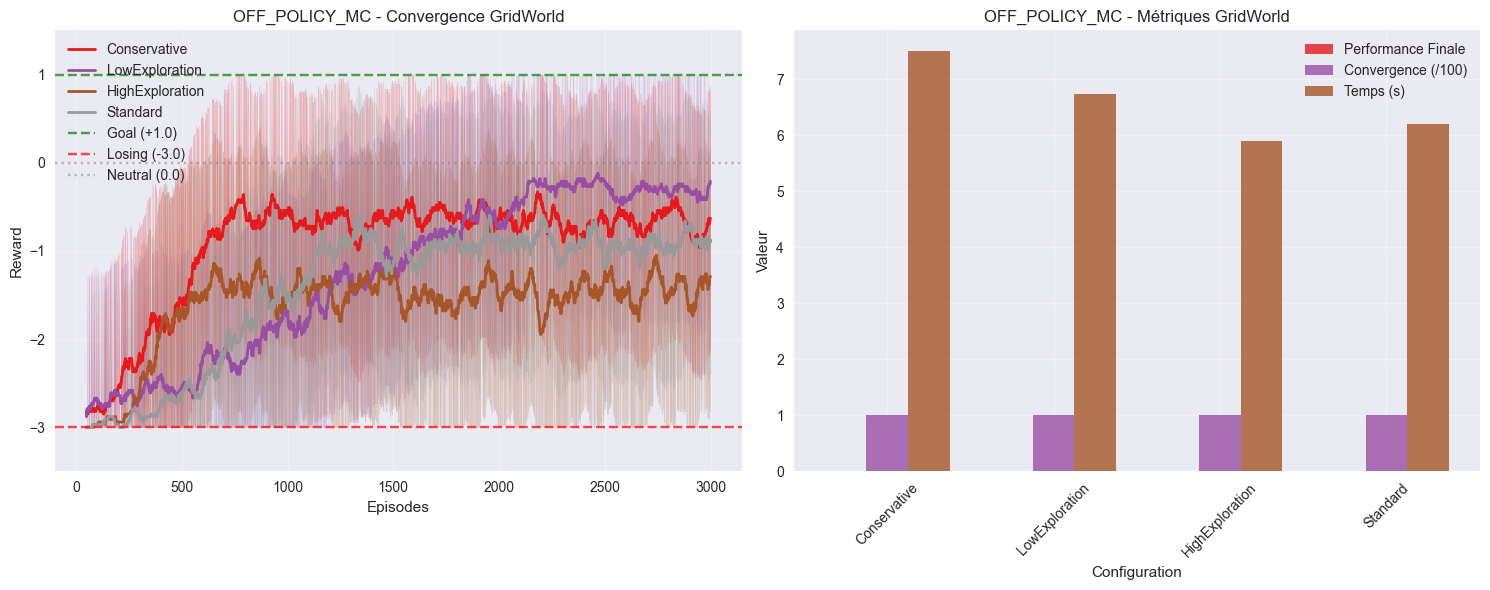

Graphique sauvegardé pour off_policy_mc

 DYNA_Q
------------------------------
Meilleure configuration: Standard
Performance moyenne: 0.5000
Convergence moyenne: 100.0 épisodes
Temps moyen: 7.663s


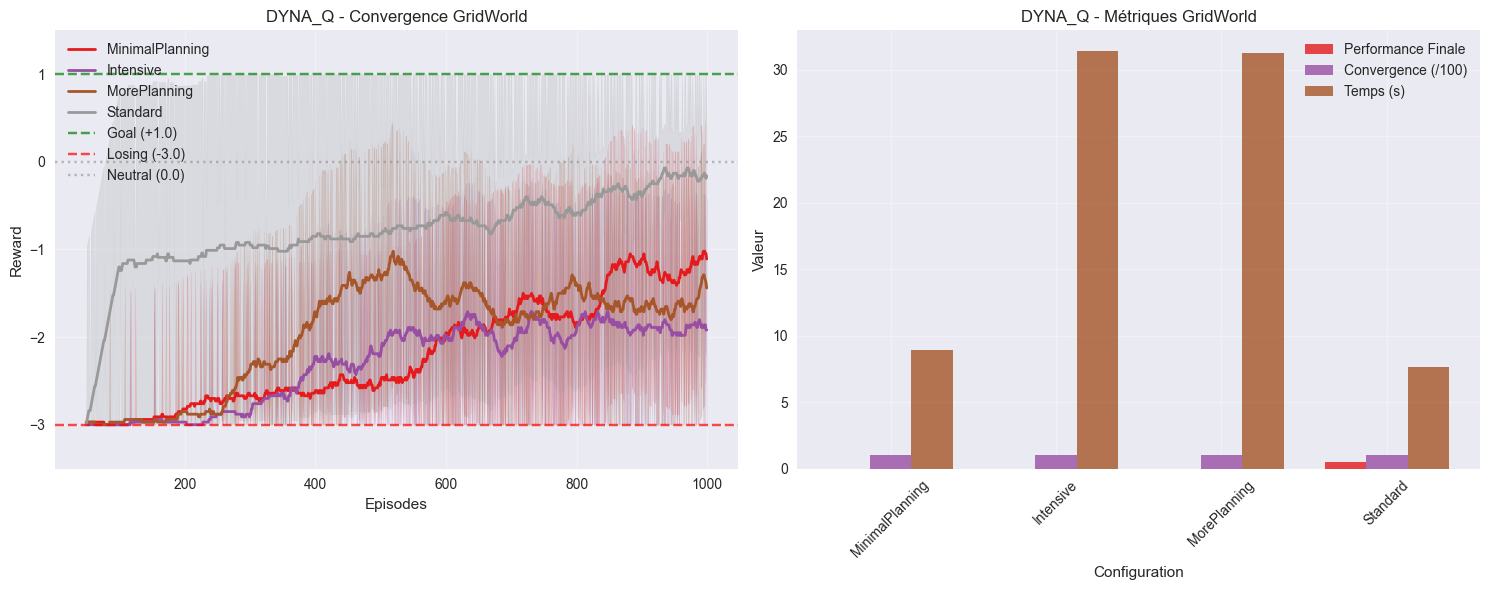

Graphique sauvegardé pour dyna_q

 COMPARAISON GLOBALE DES ALGORITHMES - GRIDWORLD
 CLASSEMENT PAR PERFORMANCE:
----------------------------------------
1 SARSA (Balanced) - 1.0000
2 VALUE_ITERATION (Fast) - 1.0000
3 POLICY_ITERATION (Fast) - 1.0000
4. MONTE_CARLO_ES (Balanced) - 1.0000
5. ON_POLICY_MC (HighExploration) - 1.0000
6. DYNA_Q (Standard) - 0.5000
7. Q_LEARNING (Aggressive) - 0.0000
8. OFF_POLICY_MC (Conservative) - 0.0000


In [31]:
# 7. ANALYSE DES PERFORMANCES PAR ALGORITHME

print("\n🔍 ANALYSE DÉTAILLÉE PAR ALGORITHME - GRIDWORLD")
print("=" * 50)

# Analyser chaque algorithme individuellement
algorithm_summaries = {}

for algorithm in results_df["algorithm"].unique():
    print(f"\n {algorithm.upper()}")
    print("-" * 30)

    algo_data = results_df[results_df["algorithm"] == algorithm]

    # Meilleure configuration
    config_performance = (
        algo_data.groupby("config_name")
        .agg({
            "final_performance": ["mean", "std"],
            "convergence_episode": "mean",
            "training_time": "mean",
            "success_rate": "mean",
            "stability": "mean",
        })
        .round(4)
    )

    best_config = config_performance["final_performance"]["mean"].idxmax()
    best_performance = config_performance.loc[best_config, ("final_performance", "mean")]

    print(f"Meilleure configuration: {best_config}")
    print(f"Performance moyenne: {best_performance:.4f}")
    print(f"Convergence moyenne: {config_performance.loc[best_config, ('convergence_episode', 'mean')]:.1f} épisodes")
    print(f"Temps moyen: {config_performance.loc[best_config, ('training_time', 'mean')]:.3f}s")

    # Stocker pour comparaison globale
    algorithm_summaries[algorithm] = {
        "best_config": best_config,
        "best_performance": best_performance,
        "convergence": config_performance.loc[best_config, ("convergence_episode", "mean")],
        "training_time": config_performance.loc[best_config, ("training_time", "mean")],
        "success_rate": config_performance.loc[best_config, ("success_rate", "mean")],
        "stability": config_performance.loc[best_config, ("stability", "mean")],
    }

    # Graphique de convergence pour cet algorithme
    algo_results = [r for r in all_results if r["algorithm"] == algorithm]
    if algo_results:
        metrics_df = plot_algorithm_convergence(algo_results, algorithm, OUTPUT_DIR)
        print(f"Graphique sauvegardé pour {algorithm}")

print("\n COMPARAISON GLOBALE DES ALGORITHMES - GRIDWORLD")
print("=" * 50)

# Création du DataFrame de comparaison
comparison_data = []
for algo, stats in algorithm_summaries.items():
    comparison_data.append({
        "Algorithm": algo,
        "Best_Config": stats["best_config"],
        "Performance": stats["best_performance"],
        "Convergence_Episodes": stats["convergence"],
        "Training_Time": stats["training_time"],
        "Success_Rate": stats["success_rate"],
        "Stability": stats["stability"],
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values("Performance", ascending=False)

print(" CLASSEMENT PAR PERFORMANCE:")
print("-" * 40)
for i, row in comparison_df.iterrows():
    rank = comparison_df.index.get_loc(i) + 1
    medal = "1" if rank == 1 else "2" if rank == 2 else "3" if rank == 3 else f"{rank}."
    print(f"{medal} {row['Algorithm'].upper()} ({row['Best_Config']}) - {row['Performance']:.4f}")



📊 VISUALISATIONS GRIDWORLD
----------------------------------------


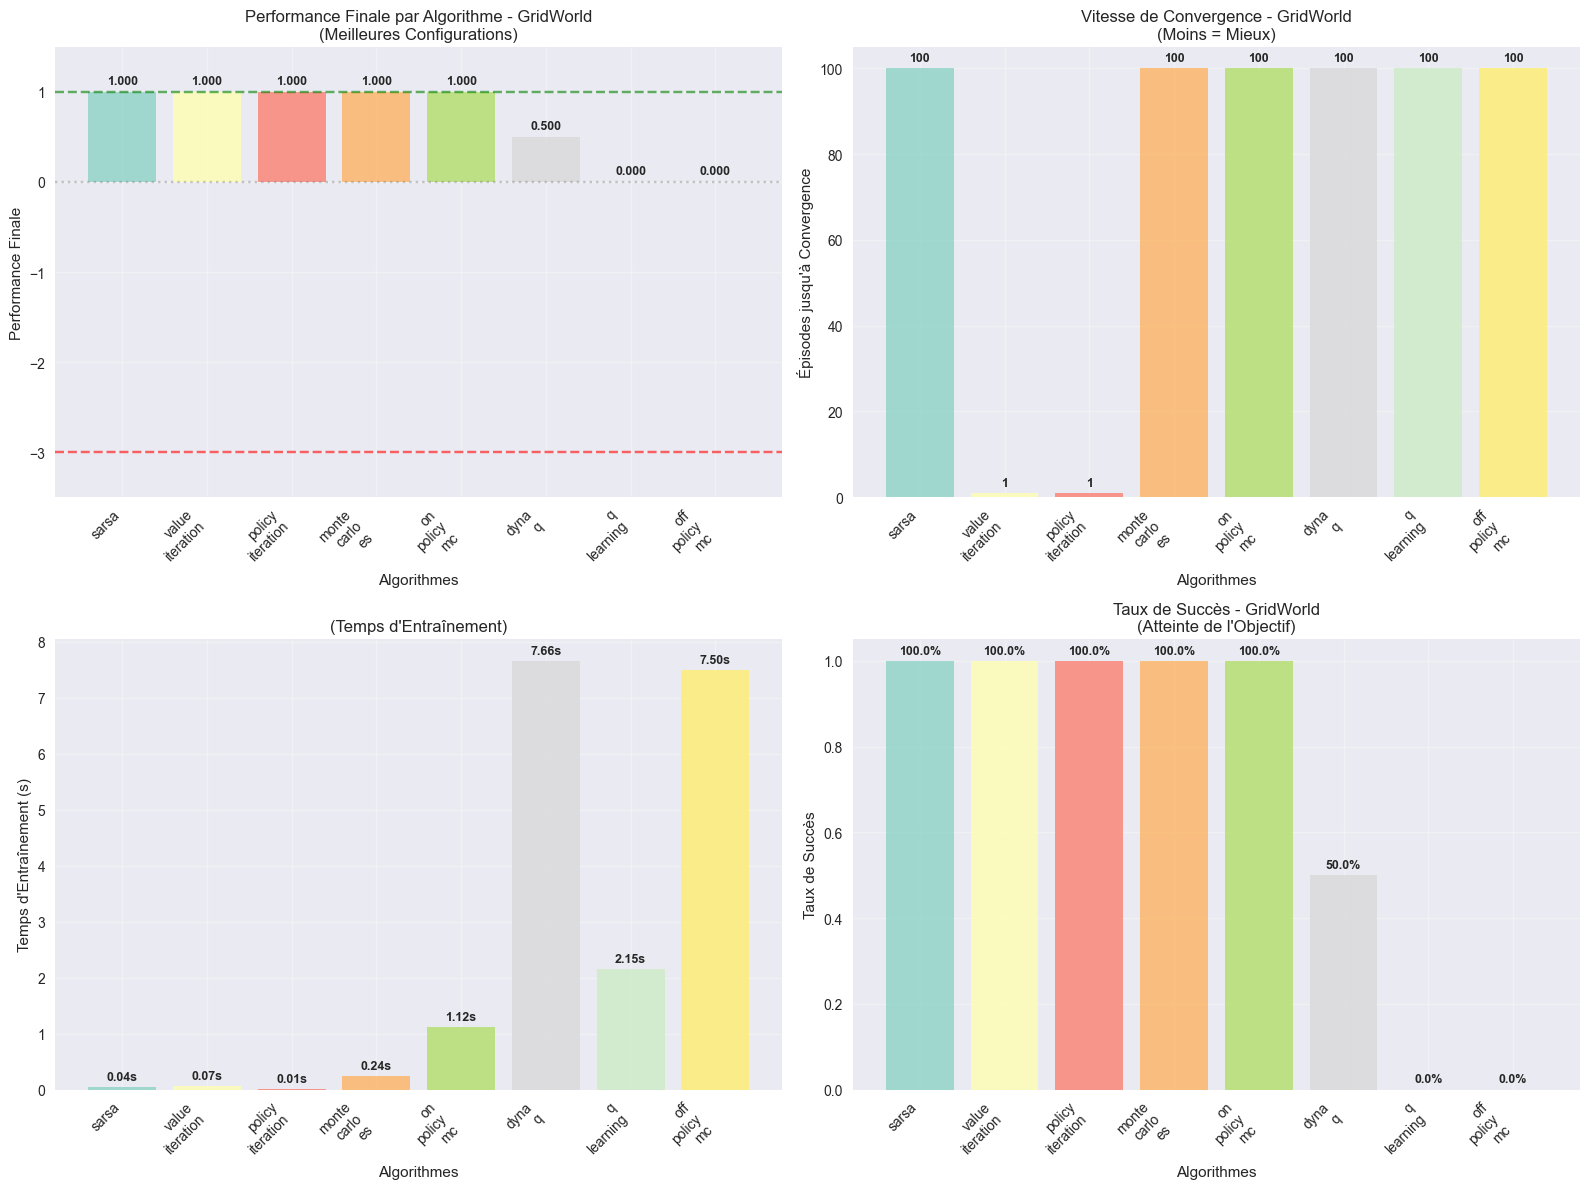

In [32]:
# 8. VISUALISATIONS GLOBALES

print("\n📊 VISUALISATIONS GRIDWORLD")
print("-" * 40)

# Figure comparative globale adaptée pour GridWorld
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

algorithms = comparison_df["Algorithm"].values
performances = comparison_df["Performance"].values
convergences = comparison_df["Convergence_Episodes"].values
times = comparison_df["Training_Time"].values
success_rates = comparison_df["Success_Rate"].values

# Couleurs distinctes pour chaque algorithme
colors = plt.cm.Set3(np.linspace(0, 1, len(algorithms)))

# Graphique 1: Performance finale - ADAPTÉ GRIDWORLD
bars1 = ax1.bar(range(len(algorithms)), performances, color=colors, alpha=0.8)
ax1.set_xlabel("Algorithmes")
ax1.set_ylabel("Performance Finale")
ax1.set_title("Performance Finale par Algorithme - GridWorld\n(Meilleures Configurations)")
ax1.set_xticks(range(len(algorithms)))
ax1.set_xticklabels([alg.replace("_", "\n") for alg in algorithms], rotation=45, ha="right")
ax1.grid(True, alpha=0.3)

ax1.set_ylim([-3.5, 1.5])

# Lignes de référence GridWorld
ax1.axhline(y=1.0, color="green", linestyle="--", alpha=0.6, label="Goal (+1.0)")
ax1.axhline(y=-3.0, color="red", linestyle="--", alpha=0.6, label="Losing (-3.0)")
ax1.axhline(y=0.0, color="gray", linestyle=":", alpha=0.4, label="Neutral (0.0)")

# Ajout des valeurs sur les barres
for i, (bar, value) in enumerate(zip(bars1, performances)):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
             f"{value:.3f}", ha="center", va="bottom", fontweight="bold", fontsize=9)

# Graphique 2: Vitesse de convergence
bars2 = ax2.bar(range(len(algorithms)), convergences, color=colors, alpha=0.8)
ax2.set_xlabel("Algorithmes")
ax2.set_ylabel("Épisodes jusqu'à Convergence")
ax2.set_title("Vitesse de Convergence - GridWorld\n(Moins = Mieux)")
ax2.set_xticks(range(len(algorithms)))
ax2.set_xticklabels([alg.replace("_", "\n") for alg in algorithms], rotation=45, ha="right")
ax2.grid(True, alpha=0.3)

for i, (bar, value) in enumerate(zip(bars2, convergences)):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + max(convergences) * 0.01,
             f"{int(value)}", ha="center", va="bottom", fontweight="bold", fontsize=9)

# Graphique 3: Temps d'entraînement
bars3 = ax3.bar(range(len(algorithms)), times, color=colors, alpha=0.8)
ax3.set_xlabel("Algorithmes")
ax3.set_ylabel("Temps d'Entraînement (s)")
ax3.set_title("(Temps d'Entraînement)")
ax3.set_xticks(range(len(algorithms)))
ax3.set_xticklabels([alg.replace("_", "\n") for alg in algorithms], rotation=45, ha="right")
ax3.grid(True, alpha=0.3)

for i, (bar, value) in enumerate(zip(bars3, times)):
    ax3.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + max(times) * 0.01,
             f"{value:.2f}s", ha="center", va="bottom", fontweight="bold", fontsize=9)

# Graphique 4: Taux de succès
bars4 = ax4.bar(range(len(algorithms)), success_rates, color=colors, alpha=0.8)
ax4.set_xlabel("Algorithmes")
ax4.set_ylabel("Taux de Succès")
ax4.set_title("Taux de Succès - GridWorld\n(Atteinte de l'Objectif)")
ax4.set_xticks(range(len(algorithms)))
ax4.set_xticklabels([alg.replace("_", "\n") for alg in algorithms], rotation=45, ha="right")
ax4.grid(True, alpha=0.3)

for i, (bar, value) in enumerate(zip(bars4, success_rates)):
    ax4.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{value:.1%}", ha="center", va="bottom", fontweight="bold", fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "global_comparison_gridworld.png", dpi=300, bbox_inches="tight")
plt.show()


 ANALYSE PAR CATÉGORIE D'ALGORITHMES - GRIDWORLD
 STATISTIQUES PAR CATÉGORIE - GRIDWORLD:
----------------------------------------

 Temporal Difference:
   Performance moyenne: 0.5000 ± 0.5164
   Convergence moyenne: 100.0 épisodes
   Temps moyen: 1.141s
   Meilleur algorithme: sarsa

 Programmation Dynamique:
   Performance moyenne: 1.0000 ± 0.0000
   Convergence moyenne: 1.0 épisodes
   Temps moyen: 0.058s
   Meilleur algorithme: value_iteration

 Monte Carlo:
   Performance moyenne: 0.6250 ± 0.4945
   Convergence moyenne: 100.0 épisodes
   Temps moyen: 2.722s
   Meilleur algorithme: monte_carlo_es

 Planning:
   Performance moyenne: 0.1250 ± 0.3536
   Convergence moyenne: 100.0 épisodes
   Temps moyen: 19.818s
   Meilleur algorithme: dyna_q


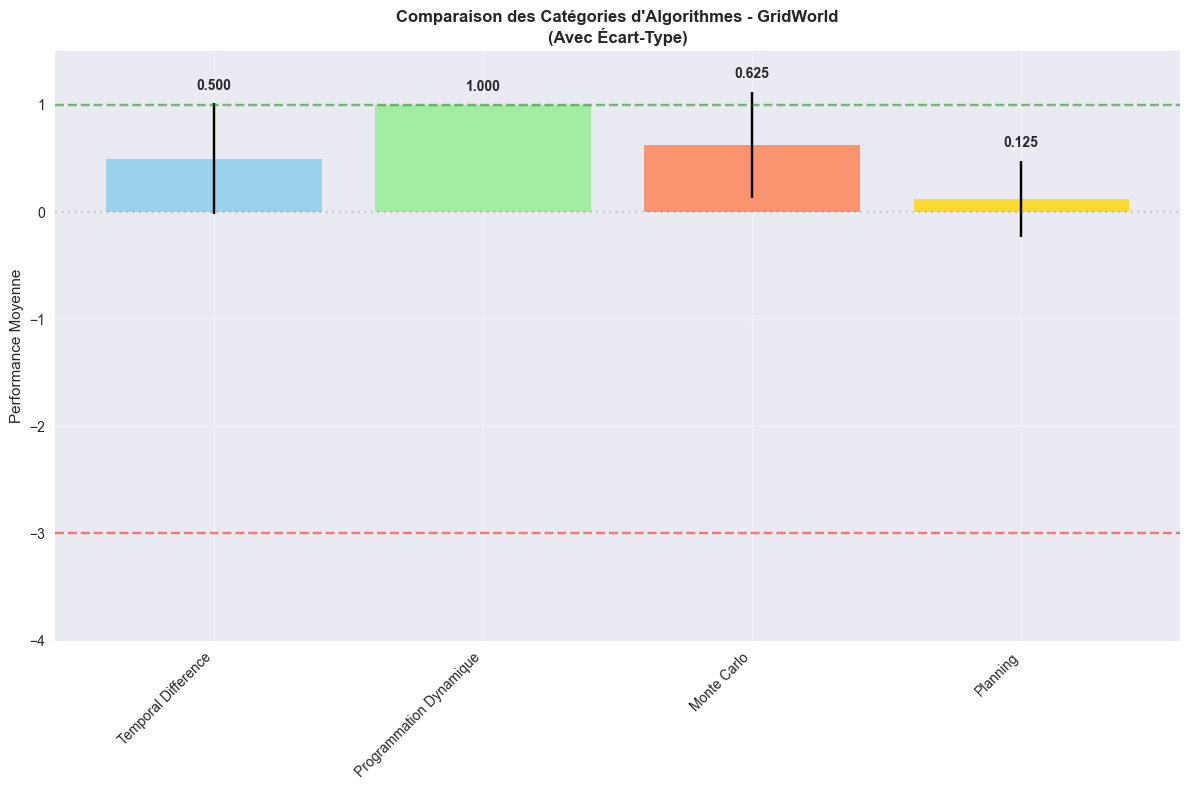

In [33]:
# 9. ANALYSE PAR CATÉGORIE D'ALGORITHMES 

print("\n ANALYSE PAR CATÉGORIE D'ALGORITHMES - GRIDWORLD")
print("=" * 50)

# Classification des algorithmes par catégorie
algorithm_categories = {
    "Temporal Difference": ["q_learning", "sarsa"],
    "Programmation Dynamique": ["value_iteration", "policy_iteration"],
    "Monte Carlo": ["monte_carlo_es", "on_policy_mc", "off_policy_mc"],
    "Planning": ["dyna_q"],
}

category_analysis = []

for category, algorithms in algorithm_categories.items():
    category_data = results_df[results_df["algorithm"].isin(algorithms)]

    if len(category_data) > 0:
        stats = {
            "Category": category,
            "Num_Algorithms": len(algorithms),
            "Avg_Performance": category_data["final_performance"].mean(),
            "Std_Performance": category_data["final_performance"].std(),
            "Avg_Convergence": category_data["convergence_episode"].mean(),
            "Avg_Time": category_data["training_time"].mean(),
            "Best_Algorithm": category_data.loc[
                category_data["final_performance"].idxmax(), "algorithm"
            ],
        }
        category_analysis.append(stats)

category_df = pd.DataFrame(category_analysis)

print(" STATISTIQUES PAR CATÉGORIE - GRIDWORLD:")
print("-" * 40)
for _, row in category_df.iterrows():
    print(f"\n {row['Category']}:")
    print(f"   Performance moyenne: {row['Avg_Performance']:.4f} ± {row['Std_Performance']:.4f}")
    print(f"   Convergence moyenne: {row['Avg_Convergence']:.1f} épisodes")
    print(f"   Temps moyen: {row['Avg_Time']:.3f}s")
    print(f"   Meilleur algorithme: {row['Best_Algorithm']}")

# Graphique comparatif par catégorie
fig, ax = plt.subplots(figsize=(12, 8))
categories = category_df["Category"].values
performances = category_df["Avg_Performance"].values
stds = category_df["Std_Performance"].values

bars = ax.bar(categories, performances, yerr=stds, capsize=5,
              color=["skyblue", "lightgreen", "coral", "gold"], alpha=0.8)

ax.set_ylabel("Performance Moyenne")
ax.set_title("Comparaison des Catégories d'Algorithmes - GridWorld\n(Avec Écart-Type)", 
             fontweight="bold")
ax.grid(True, alpha=0.3)

ax.set_ylim([-4.0, 1.5])

# Lignes de référence GridWorld
ax.axhline(y=1.0, color="green", linestyle="--", alpha=0.5, label="Goal (+1.0)")
ax.axhline(y=-3.0, color="red", linestyle="--", alpha=0.5, label="Losing (-3.0)")
ax.axhline(y=0.0, color="gray", linestyle=":", alpha=0.3, label="Neutral (0.0)")

# Rotation des labels si nécessaire
plt.xticks(rotation=45, ha="right")

# Ajout des valeurs sur les barres
for bar, value, std in zip(bars, performances, stds):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + std + 0.1,
            f"{value:.3f}", ha="center", va="bottom", fontweight="bold")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "category_comparison_gridworld.png", dpi=300, bbox_inches="tight")
plt.show()

In [34]:
# Identification des meilleurs algorithmes selon différents critères
best_overall = comparison_df.iloc[0]  # Premier du classement par performance
fastest_convergence = comparison_df.loc[comparison_df["Convergence_Episodes"].idxmin()]
most_efficient = comparison_df.loc[comparison_df["Training_Time"].idxmin()]
highest_success = comparison_df.loc[comparison_df["Success_Rate"].idxmax()]

In [35]:
print(f"\n CONCLUSION - GRIDWORLD:")
print("-" * 50)

if len(comparison_df) > 0:
    top_3_algos = comparison_df.head(3)
    
    for i, (_, row) in enumerate(top_3_algos.iterrows(), 1):
        print(f"\n{i}. {row['Algorithm'].upper()} ({row['Best_Config']}):")
        print(f"   • Performance: {row['Performance']:.4f}")
        print(f"   • Convergence: {row['Convergence_Episodes']:.0f} épisodes")
        print(f"   • Temps: {row['Training_Time']:.3f}s")
    



 CONCLUSION - GRIDWORLD:
--------------------------------------------------

1. SARSA (Balanced):
   • Performance: 1.0000
   • Convergence: 100 épisodes
   • Temps: 0.041s

2. VALUE_ITERATION (Fast):
   • Performance: 1.0000
   • Convergence: 1 épisodes
   • Temps: 0.067s

3. POLICY_ITERATION (Fast):
   • Performance: 1.0000
   • Convergence: 1 épisodes
   • Temps: 0.010s


In [36]:
# 12. EXPORT ET SAUVEGARDE DES RÉSULTATS
print("\n EXPORT DES RÉSULTATS GRIDWORLD")
print("=" * 40)

# Sauvegarde du DataFrame principal
results_export = results_df[["algorithm", "config_name", "final_performance", 
                           "convergence_episode", "training_time", "success_rate", "stability"]].copy()

# Export du classement final
comparison_export = comparison_df[["Algorithm", "Best_Config", "Performance", 
                                 "Convergence_Episodes", "Training_Time", "Success_Rate"]].copy()

# Rapport synthèse textuel pour GridWorld
report_path = OUTPUT_DIR / "gridworld_analysis_report.txt"
with open(report_path, "w", encoding="utf-8") as f:
    f.write("RAPPORT D'ANALYSE - GRIDWORLD ENVIRONMENT\n")
    f.write("=" * 50 + "\n\n")

    f.write("MÉTHODOLOGIE:\n")
    f.write("-" * 15 + "\n")
    f.write(f"• Environnement: GridWorld (5x5 grille, 25 états, 4 actions)\n")
    f.write(f"• Positions spéciales: Start (0,0), Goal (4,4), Losing (4,0)\n")
    f.write(f"• Récompenses: Goal +1.0, Losing -3.0, Normal 0.0\n")
    f.write(f"• Algorithmes testés: {len(comparison_df)}\n")
    f.write(f"• Configurations par algorithme: 3-4\n")
    f.write(f"• Runs par configuration: {EXPERIMENT_CONFIG['num_runs_per_config']}\n")
    f.write(f"• Total expériences: {len(all_results)}\n")
    f.write(f"• Épisodes TD: {EXPERIMENT_CONFIG['num_episodes_td']}\n")
    f.write(f"• Épisodes MC: {EXPERIMENT_CONFIG['num_episodes_mc']}\n")
    f.write(f"• Épisodes évaluation: {EXPERIMENT_CONFIG['evaluation_episodes']}\n\n")

    f.write("CLASSEMENT FINAL - GRIDWORLD:\n")
    f.write("-" * 30 + "\n")
    for i, (_, row) in enumerate(comparison_df.iterrows(), 1):
        f.write(f"{i}. {row['Algorithm'].upper()} ({row['Best_Config']})\n")
        f.write(f"   Performance: {row['Performance']:.4f}\n")
        f.write(f"   Convergence: {row['Convergence_Episodes']:.0f} épisodes\n")
        f.write(f"   Temps: {row['Training_Time']:.3f}s\n")
        f.write(f"   Succès: {row['Success_Rate']:.2%}\n\n")

    f.write("CONCLUSIONS:\n")
    f.write("-" * 28 + "\n")
    f.write(f"• Meilleure performance globale: {best_overall['Algorithm'].upper()}\n")
    f.write(f"• Convergence la plus rapide: {fastest_convergence['Algorithm'].upper()}\n")


    f.write("ANALYSE PAR CATÉGORIE - GRIDWORLD:\n")
    f.write("-" * 35 + "\n")
    for _, row in category_df.iterrows():
        f.write(f"• {row['Category']}: {row['Avg_Performance']:.4f} ± {row['Std_Performance']:.4f}\n")
        f.write(f"  Meilleur: {row['Best_Algorithm']}\n")


print(f" Rapport sauvegardé: {report_path}")

# Sauvegarde des métriques de performance
metrics_path = OUTPUT_DIR / "performance_metrics_gridworld.json"
metrics_data = {
    "experiment_config": EXPERIMENT_CONFIG,
    "environment_info": {
        "name": "GridWorld",
        "size": "5x5",
        "states": 25,
        "actions": 4,
        "reward_range": [-3.0, 1.0],
        "special_positions": {
            "start": [0, 0],
            "goal": [4, 4], 
            "losing": [4, 0]
        }
    },
    "algorithm_ranking": comparison_df.to_dict("records"),
    "category_analysis": category_df.to_dict("records"),
    "trade_offs": {
        "best_performance": best_overall.to_dict(),
        "fastest_convergence": fastest_convergence.to_dict(),
        "most_efficient": most_efficient.to_dict(),
        "highest_success": highest_success.to_dict(),
    },
    "summary_stats": {
        "total_experiments": len(all_results),
        "failed_experiments": len(failed_experiments),
        "algorithms_tested": len(comparison_df),
        "best_algorithm": best_overall["Algorithm"],
        "best_performance": float(best_overall["Performance"]),
    },
    "gridworld_insights": {
        "complexity_vs_lineworld": "5x more states, 2x more actions",
        "key_challenges": ["exploration", "trap_avoidance", "long_trajectories"],
        "optimal_hyperparams": {
            "epsilon_range": [0.15, 0.3],
            "gamma_range": [0.95, 0.99],
            "episodes_recommended": [2000, 3000]
        }
    }
}

with open(metrics_path, "w") as f:
    json.dump(metrics_data, f, indent=2)

print(f"💾 Métriques sauvegardées: {metrics_path}")


 EXPORT DES RÉSULTATS GRIDWORLD
 Rapport sauvegardé: ../outputs/grid_world/gridworld_analysis_report.txt
💾 Métriques sauvegardées: ../outputs/grid_world/performance_metrics_gridworld.json
